### Select N-words with higher TF

In [ ]:
import pandas as pd
import sys
import os
import re
sys.path.append(r"C:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\myLibraries")
from MARScore.score import MARSCore
from MARScore.utils import *

In [ ]:
dataset = pd.read_json(r'C:\Pro\Stages\A4 - DVRC\Work\Datasets\pubmed\test.json', lines=True)
dataset = dataset[["article_text", "abstract_text"]]
cleaner = lambda x: ". ".join(x).replace("<S>", "").strip()
format_dot = lambda x: x.replace(" .", ".")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"article_text"] = dataset["article_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleaner)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleaner)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleanString)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleanString)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(format_dot)
dataset.loc[:,"article_text"] = dataset["article_text"].map(format_dot)
dataset = dataset.rename(columns={"abstract_text": "summary",
                        "article_text": "text"})

subset = dataset.iloc[3:5, :]
subset

In [ ]:
all_tf = []
for indiv in subset["text"].to_list():
    o, l = tokenizeCorpus(indiv)
    v = vectorizeCorpus(o)
    v, l = cleanAll(v, l)
    all_tf.append(tf(l))

In [ ]:
all_tf

In [ ]:
def best_words_format(tfs, n):
    output = "Maximize\nscore: "
    for i, v in enumerate(tfs.values()):
        output += f"+ {v} c{i}"
    
    output += "\n\nSubject To\n"
    output += "length:"
    for i, v in enumerate(tfs.values()):
        output += f" c{i} +"
    output = output[:-1]
    output += f"< {n}"

    output += "\n\nBinary\n"
    for i, v in enumerate(tfs.values()):
        output += f"c{i}\n"
    return output


In [ ]:
format = best_words_format(all_tf[0], 4)

with open(os.path.join(get_git_root(), r"myLibraries\ilp_outputs\ilp_in.ilp"), "w") as f:
    f.write(format)
    f.close()

os.system(f'glpsol --tmlim 100 --lp "{os.path.join(get_git_root(), r"myLibraries/ilp_outputs/ilp_in.ilp")}" -o "{os.path.join(get_git_root(), r"myLibraries/ilp_outputs/ilp_out.sol")}"')

with open(os.path.join(get_git_root(), r"myLibraries/ilp_outputs/ilp_out.sol"), "r") as f:
    lines = f.readlines()
    f.close()

sentences_lines = [line for line in lines if re.search(r"c\d", line)]

sorted_lines = sorted(sentences_lines, key=lambda line: int(line.split()[1][1:]))
result = [int(sorted_line.split()[3]) for sorted_line in sorted_lines]

In [ ]:
index = [i for i, value in enumerate(result) if value == 1]
index

In [ ]:
ref = []
for i, (k, v) in enumerate(all_tf[0].items()):
    ref.append([i, k, v])
ref.sort(key=lambda x: x[2], reverse=True)
res = [v[0] for v in ref[:4]]
res

### Select N-sentences maximizing words tfs

In [ ]:
import pandas as pd
import sys
import os
import re
sys.path.append(r"C:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\myLibraries")
from MARScore.score import MARSCore
from MARScore.utils import *

In [ ]:
dataset = pd.read_json(r'C:\Pro\Stages\A4 - DVRC\Work\Datasets\pubmed\test.json', lines=True)
dataset = dataset[["article_text", "abstract_text"]]
cleaner = lambda x: ". ".join(x).replace("<S>", "").strip()
format_dot = lambda x: x.replace(" .", ".")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"article_text"] = dataset["article_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleaner)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleaner)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleanString)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleanString)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(format_dot)
dataset.loc[:,"article_text"] = dataset["article_text"].map(format_dot)
dataset = dataset.rename(columns={"abstract_text": "summary",
                        "article_text": "text"})

subset = dataset.iloc[3:5, :]
subset

In [ ]:
all_tokens = []
all_tf = []
for indiv in subset["text"].to_list():
    o, l = tokenizeCorpus(indiv)
    v = vectorizeCorpus(o)
    v, l = cleanAll(v, l)
    tfs = tf(l)

    all_tokens.append(l)
    all_tf.append(tfs)

In [ ]:
def best_sentences_format(tokens, tfs, n):
    ### sentence tfs
    i = 0
    sentences_tfs = {}
    for token in tokens:
        if i in sentences_tfs.keys():
            sentences_tfs[i] += tfs[token]
        else:
            sentences_tfs[i] = tfs[token]
        if token == ".":
            i += 1
    
    output = "Maximize\nscore:"
    for i, cur_tf in enumerate(sentences_tfs.values()):
        output += f"+ {cur_tf} s{i}"
    
    output += "\n\nSubject To\n"
    output += f"length:"
    for i in range(len(sentences_tfs.keys())):
        output += f" s{i} +"
    output = output[:-1]
    output += f"< {n}"

    output += "\n\nBinary"
    for i in range(len(sentences_tfs.keys())):
        output += f"\ns{i}"
    return output

In [ ]:
format = best_sentences_format(all_tokens[1], all_tf[1], 4)

with open(os.path.join(get_git_root(), r"myLibraries\ilp_outputs\ilp_in.ilp"), "w") as f:
    f.write(format)
    f.close()

os.system(f'glpsol --tmlim 100 --lp "{os.path.join(get_git_root(), r"myLibraries/ilp_outputs/ilp_in.ilp")}" -o "{os.path.join(get_git_root(), r"myLibraries/ilp_outputs/ilp_out.sol")}"')

with open(os.path.join(get_git_root(), r"myLibraries/ilp_outputs/ilp_out.sol"), "r") as f:
    lines = f.readlines()
    f.close()

sentences_lines = [line for line in lines if re.search(r"s\d", line)]

sorted_lines = sorted(sentences_lines, key=lambda line: int(line.split()[1][1:]))
result = [int(sorted_line.split()[3]) for sorted_line in sorted_lines]

In [ ]:
index = [i for i, value in enumerate(result) if value == 1]
index

In [ ]:
ref = []
### sentence tfs
i = 0
sentences_tfs = {}
for token in all_tokens[1]:
    if i in sentences_tfs.keys():
        sentences_tfs[i] += all_tf[1][token]
    else:
        sentences_tfs[i] = all_tf[1][token]
    if token == ".":
        i += 1


for i, (k, v) in enumerate(sentences_tfs.items()):
    ref.append([i, k, v])
ref.sort(key=lambda x: x[2], reverse=True)
res = [v[0] for v in ref[:4]]
res.sort()
res

### Convex Hull and Inner Cluster Distance

In [ ]:
import pandas as pd
import sys
import os
import re
sys.path.append(r"C:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\myLibraries")
from MARScore.score import MARSCore
from MARScore.utils import *
from hdbscan import HDBSCAN
from umap import UMAP
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt

In [ ]:
dataset = pd.read_json(r'C:\Pro\Stages\A4 - DVRC\Work\Datasets\pubmed\test.json', lines=True)
dataset = dataset[["article_text", "abstract_text"]]
cleaner = lambda x: ". ".join(x).replace("<S>", "").strip()
format_dot = lambda x: x.replace(" .", ".")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"article_text"] = dataset["article_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleaner)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleaner)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleanString)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleanString)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(format_dot)
dataset.loc[:,"article_text"] = dataset["article_text"].map(format_dot)
dataset = dataset.rename(columns={"abstract_text": "summary",
                        "article_text": "text"})

subset = dataset.iloc[3:5, :]
subset

In [ ]:
all_embs = []
all_reduced_embs = []
all_tokens = []
all_clabels = []
for indiv in subset["text"].to_list():
    o, l = tokenizeCorpus(indiv)
    v = vectorizeCorpus(o, method="concat_l4")
    v, l = cleanAll(v, l)
    reduced_v, clabels = clusterizeCorpus(UMAP(n_components=2, init="random", random_state=0), v, 
                                        HDBSCAN())
    tf_values = tf(l)
    clusters_tf_values = clusters_tf(tf_values, l, clabels)
    all_embs.append(v)
    all_reduced_embs.append(reduced_v)
    all_tokens.append(l)
    all_clabels.append(clabels)

In [ ]:
def tidy_tokens(tokens, clabels, embs):
    d = {}
    for token, clabel, emb in zip(tokens, clabels, embs):
        if clabel in d.keys():
            d[clabel]["tokens"].append(token)
            d[clabel]["embs"].append(emb)
        else:
            d[clabel] = {"tokens": [token], "embs": [emb]}
    return d

In [ ]:
d_tokens = tidy_tokens(all_tokens[0], all_clabels[0], all_reduced_embs[0])
for k, v in d_tokens.items():
    d_tokens[k]["embs"] = np.array(v["embs"])
convex_hulls = {k: ConvexHull(v["embs"]) for k, v in d_tokens.items()}

In [ ]:
points = d_tokens[0]["embs"]
hull = ConvexHull(points)

# Get the indices of the points forming the convex hull
hull_indices = hull.vertices
hull_indices = np.append(hull_indices, hull.vertices[0])

# Plotting
plt.figure()
plt.plot(points[:, 0], points[:, 1], 'ko', label='Points')
plt.plot(points[hull_indices, 0], points[hull_indices, 1], 'r-', lw=2, label='Convex Hull')
for x, y, index in zip(points[hull_indices, 0], points[hull_indices, 1], hull_indices):
    plt.text(x, y, str(index))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Convex Hull')
plt.legend()
plt.show()

In [ ]:
def euclideanDistance(p, q):
    p = np.array(p)
    q = np.array(q)
    return np.linalg.norm(p - q)
   

def crossProduct(p, q, r):
    pq = np.array(q) - np.array(p)
    pr = np.array(r) - np.array(p)
    return np.cross(pq, pr)
    

def rotatingCaliper(points, convex_hull):
   
    # Takes O(n)
    hull = [points[i] for i in range(len(points)) if i in convex_hull.vertices]
    n = len(hull)
 
    # Base Cases
    if n == 1:
        return 0
    if n == 2:
        return euclideanDistance(hull[0], hull[1])
    k = 1
 
    # Find the farthest vertex
    # from hull[0] and hull[n-1]
    while crossProduct(hull[n - 1], hull[0], hull[(k + 1) % n]) > crossProduct(hull[n - 1], hull[0], hull[k]):
        k += 1
 
    res = 0
 
    # Check points from 0 to k
    for i in range(k + 1):
        j = (i + 1) % n
        while crossProduct(hull[i], hull[(i + 1) % n], hull[(j + 1) % n]) > crossProduct(hull[i], hull[(i + 1) % n], hull[j]):
            # Update res
            res = max(res, euclideanDistance(hull[i], hull[(j + 1) % n]))
            j = (j + 1) % n
 
    # Return the result distance
    return res

def biggerDistance(points):
    points = np.array(points)
    convex_hull = ConvexHull(points)
    return rotatingCaliper(points, convex_hull)

# Code inspired by amit_mangal_ on geeksforgeeks forum

In [ ]:
rotatingCaliper(d_tokens[0]["embs"], convex_hulls[0]) #complexity = O(N*log(N))

In [ ]:
biggerDistance(d_tokens[0]["embs"])

### Relevancy score

In [ ]:
import pandas as pd
import sys
import os
import re
sys.path.append(r"C:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\myLibraries")
from MARScore.score import MARSCore
from MARScore.utils import *
from hdbscan import HDBSCAN
from umap import UMAP
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt

In [ ]:
dataset = pd.read_json(r'C:\Pro\Stages\A4 - DVRC\Work\Datasets\pubmed\test.json', lines=True)
dataset = dataset[["article_text", "abstract_text"]]
cleaner = lambda x: ". ".join(x).replace("<S>", "").strip()
format_dot = lambda x: x.replace(" .", ".")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"article_text"] = dataset["article_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleaner)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleaner)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleanString)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleanString)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(format_dot)
dataset.loc[:,"article_text"] = dataset["article_text"].map(format_dot)
dataset = dataset.rename(columns={"abstract_text": "summary",
                        "article_text": "text"})

subset = dataset.iloc[3:5, :]
subset

In [ ]:
all_embs = []
all_reduced_embs = []
all_tokens = []
all_clabels = []
for indiv in subset["text"].to_list():
    o, l = tokenizeCorpus(indiv)
    v = vectorizeCorpus(o, method="concat_l4")
    v, l = cleanAll(v, l)
    reduced_v, clabels = clusterizeCorpus(UMAP(n_components=2, init="random", random_state=0), v, 
                                        HDBSCAN())
    tf_values = tf(l)
    clusters_tf_values = clusters_tf(tf_values, l, clabels)
    all_embs.append(v)
    all_reduced_embs.append(reduced_v)
    all_tokens.append(l)
    all_clabels.append(clabels)

In [ ]:
def tidy_tokens(tokens, clabels, embs):
    d = {}
    for token, clabel, emb in zip(tokens, clabels, embs):
        if clabel in d.keys():
            d[clabel]["tokens"].append(token)
            d[clabel]["embs"].append(emb)
        else:
            d[clabel] = {"tokens": [token], "embs": [emb]}
    return d

In [ ]:
d_tokens = tidy_tokens(all_tokens[1], all_clabels[1], all_reduced_embs[1])
for k, v in d_tokens.items():
    d_tokens[k]["embs"] = np.array(v["embs"])

In [ ]:
def euclideanDistance(p, q):
    p = np.array(p)
    q = np.array(q)
    return np.linalg.norm(p - q)


def crossProduct(p, q, r):
    pq = np.array(q) - np.array(p)
    pr = np.array(r) - np.array(p)
    return np.cross(pq, pr)


def rotatingCaliper(points, convex_hull):
   
    # Takes O(n)
    hull = [points[i] for i in range(len(points)) if i in convex_hull.vertices]
    n = len(hull)
 
    # Base Cases
    if n == 1:
        return 0
    if n == 2:
        return euclideanDistance(hull[0], hull[1])
    k = 1
 
    # Find the farthest vertex
    # from hull[0] and hull[n-1]
    while crossProduct(hull[n - 1], hull[0], hull[(k + 1) % n]) > crossProduct(hull[n - 1], hull[0], hull[k]):
        k += 1
 
    res = 0
 
    # Check points from 0 to k
    for i in range(k + 1):
        j = (i + 1) % n
        while crossProduct(hull[i], hull[(i + 1) % n], hull[(j + 1) % n]) > crossProduct(hull[i], hull[(i + 1) % n], hull[j]):
            # Update res
            res = max(res, euclideanDistance(hull[i], hull[(j + 1) % n]))
            j = (j + 1) % n
 
    # Return the result distance
    return res

def biggerDistance(points):
    points = np.array(points)
    convex_hull = ConvexHull(points)
    return rotatingCaliper(points, convex_hull)

# Code inspired by amit_mangal_ on geeksforgeeks forum

In [ ]:
def optimized_score(tokens_dict, clusters_tfs):
    scores = {}
    for k, v in tokens_dict.items():
        try:
            max_dist = biggerDistance(v["embs"])
            scores[k] = clusters_tfs[k]/(max_dist*len(v["tokens"])) if max_dist > 0 else 0
        except:
            scores[k]=0
    return scores

In [ ]:
c_tfs = clusters_tf(tf(all_tokens[1]), all_tokens[1], all_clabels[1])

In [ ]:
optimized_score(d_tokens, c_tfs)

In [ ]:
for v in list(d_tokens.values())[:1]:
    print(v["embs"].shape)

### Redundancy score

In [1]:
import pandas as pd
import sys
import os
import re
sys.path.append(r"C:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\myLibraries")
from MARScore.score import MARSCore
from MARScore.utils import *
from hdbscan import HDBSCAN
from umap import UMAP
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt

c:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotated-Data\.venv\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Pro\Stages\A4 - DVRC\Work\Supervised-Learning-using-Unsupervised-Learning-Metrics-in-the-absence-of-Annotat

In [2]:
dataset = pd.read_json(r'C:\Pro\Stages\A4 - DVRC\Work\Datasets\pubmed\test.json', lines=True)
dataset = dataset[["article_text", "abstract_text"]]
cleaner = lambda x: ". ".join(x).replace("<S>", "").strip()
format_dot = lambda x: x.replace(" .", ".")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"article_text"] = dataset["article_text"].replace(regex=r"\[[^\]]*\]", value="")
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleaner)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleaner)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(cleanString)
dataset.loc[:,"article_text"] = dataset["article_text"].map(cleanString)
dataset.loc[:,"abstract_text"] = dataset["abstract_text"].map(format_dot)
dataset.loc[:,"article_text"] = dataset["article_text"].map(format_dot)
dataset = dataset.rename(columns={"abstract_text": "summary",
                        "article_text": "text"})

subset = dataset.iloc[3:5, :]
subset

,text,summary
3,congenital adrenal hyperplasia ( cah ) refers ...,congenital adrenal hyperplasia is a group of a...
4,type 1 diabetes ( t1d ) results from the destr...,objective(s):pentoxifylline is an immunomodula...


In [3]:
all_embs = []
all_reduced_embs = []
all_tokens = []
all_clabels = []
for indiv in subset["text"].to_list():
    o, l = tokenizeCorpus(indiv)
    v = vectorizeCorpus(o, method="concat_l4")
    v, l = cleanAll(v, l)
    reduced_v, clabels = clusterizeCorpus(UMAP(n_components=2, init="random", random_state=0), v, 
                                        HDBSCAN())
    tf_values = tf(l)
    clusters_tf_values = clusters_tf(tf_values, l, clabels)
    all_embs.append(v)
    all_reduced_embs.append(reduced_v)
    all_tokens.append(l)
    all_clabels.append(clabels)

In [4]:
def tokens_per_cluster(tokens, clabels, embs):
        """
        Groups embeddings and tokens by cluster.

        :param1 tokens (list): List of text tokens associated with each embedding.
        :param2 clabels (list): List of token's cluster index.
        :param3 embs (list): List of embedding vectors for each token.

        :output d (dict): Dictionnary containing embeddings and associated tokens for each cluster.
        """
        d = {}
        for token, clabel, emb in zip(tokens, clabels, embs):
            if clabel in d.keys():
                d[clabel]["tokens"].append(token)
                d[clabel]["embs"].append(emb)
            else:
                d[clabel] = {"tokens": [token], "embs": [emb]}
        for k, v in d.items():
            d[k]["embs"] = np.array(v["embs"])
        return d

In [16]:


def redundancy_score(d_tokens):
    """
    Evaluates redundancy in clusters. 

    :param1 d_tokens (dict): Dictionnary containing embeddings and associated tokens for each cluster.

    :output (list): Redundancy matrix for a group of clusters.
    """

    def smallest_intercluster_distance(embs1, embs2):
        """
        Determines the smallest inter-cluster distance between two clusters. 

        :param1 embs1 (list): List of embeddings for cluster 1.
        :param2 embs2 (list): List of embeddings for cluster 2.

        :output (float): Smallest inter-cluster distance.
        """
        distance_matrix = []
        for emb1 in embs1:
            temp = []
            for emb2 in embs2:
                temp.append(np.linalg.norm(emb2 - emb1))
            distance_matrix.append(temp)
        distance_matrix = np.array(distance_matrix)
        return distance_matrix.min()

    try:
        d_tokens.pop(-1)
    except KeyError:
        pass
    k = sorted(d_tokens.keys())
    l = len(k)
    m = [[0 for j in range(l)] for i in range(l)]
    for i in range(l):
        for j in range(i, l):
            m[i][j] = smallest_intercluster_distance(d_tokens[k[i]]["embs"], d_tokens[k[j]]["embs"])
    m = np.triu(m)
    m = m + m.T - np.diag(np.diag(m))
    return m

In [17]:
d_tokens = tokens_per_cluster(all_tokens[0], all_clabels[0], all_embs[0])
r_score = redundancy_score(d_tokens)

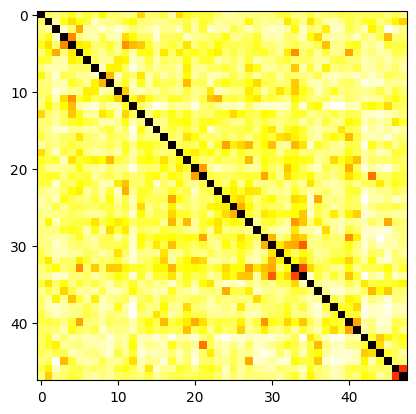

In [18]:
plt.imshow(r_score, cmap='hot', interpolation='nearest')
plt.show()

In [19]:
r_score[0][1]

42.308984989255926